# Reanalysis of Yokota et al. 2020
Akira Endo

## Introduction
A paper recently published in *Clinical Infectious Diseases*, [Yokota et al. 2020](https://doi.org/10.1093/cid/ciaa1388), compared the results of polymerase chain reaction (PCR) tests for SARS-CoV-2 between nasopharyngeal swab (NPS) and saliva samples. The authors used a Bayesian-latent class model to simultaneously estimate the sensitivity and specificity of NPS/saliva PCR tests along with the unknown prevalence in the study cohorts (contact tracing and airport screening cohorts), and reported the sensitivity of 86% and 92% for NPS and saliva samples, respectively. The specificity of both tests were estimated to be over 99.9%. Compared with NPS, saliva samples are low-invasive and requires less involvement of healthcare professionals (which could also help protecting them from infection). Yokota et al. showed that saliva samples exhibited almost equivalent performance to NPS samples, which has a profound impact on the ongoing public health planning against COVID-19 where efficient and less invasive testing protocols are of paramount importance. However we noticed, while we agree with the reported concordance between NPS and saliva tests, that the estimation model used to estimate the sensitivity (and specificity) of tests has a critical flaw and that the reported sensitivity of 86% and 92% are merely representative of positive agreement ratios (PARs) between NPS and saliva samples. Although in the model these parameters (sensitivity) are appropriately defined as "the proportion testing positive in the truely infected individuals" using a latent variable $p$ (prevalence), the following two conditions in the model resulted in the estimated sensitivity almost identical statistical quantity as the PAR:
* The results of NPS and saliva tests are assumed to be statistically independent although the authors concluded in the manuscript that they are highly correlated (with a Kendall's W of 0.87);
* The prevalence $p$ was jointly estimated with other parameters, which resulted in the estimated sensitivity value almost solely determined by the PAR in the data.

Here, we reproduce the authors' analysis and perform additional analysis to show that the presented data was barely informative to distinguish the reported sensitivity from the PAR.

## Methods
First, we reproduce the analysis in the original study. For each of the two datasets $D_i$($i=1$: contact tracing and $i=2$: airport quarantine), we denote the number of individuals in the 2-by-2 table as

|  NPS　　　　　　　　| Saliva (+) | (-) |
|---------------------|--------|-----|
| (+)                 | A      | B   |
| (-)                 | C      | D   |

Under the assumption that the nasopharyngeal swab (NSP) and saliva tests are independent, the likelihood function assuming multinomial sampling is obtained as
$$
L_i\propto q_{A_i}^{A_i}q_{B_i}^{B_i}q_{C_i}^{C_i}q_{D_i}^{D_i},
$$
where
$$
q_{A_i}=p_iSe_NSe_S+(1-p_i)(1-Sp_N)(1-Sp_S),\\
q_{B_i}=p_iSe_N(1-Se_S)+(1-p_i)(1-Sp_N)Sp_S,\\
q_{C_i}=p_i(1-Se_N)Se_S+(1-p_i)Sp_N(1-Sp_S),\\
q_{D_i}=p_i(1-Se_N)(1-Se_S)+(1-p_i)Sp_NSp_S,
$$
and we get the posterior distribution of parameters $\theta=(Se_N,Se_S,Sp_N,Sp_S,p_1,p_2)$
$$
p(\theta| D_1, D_2)\propto p(\theta)L_1L_2
$$
where $p(\theta)$ represents the product of prior distributions. Markov-chain Monte Carlo (MCMC) was used to sample posterior distributions.

## Replication results

In [1]:
# Prepare functions & data
using Distributions, Mamba, RCall, Random, Plots
function qs(senses,specs,prev)
    [[senses[1],1-senses[1]]*[senses[2],1-senses[2]]', [1-specs[1],specs[1]]*[1-specs[2],specs[2]]'].*[prev,1-prev]|>sum
end
# 2×2 data tables
ctdata=[38 3
        6 114]
aqdata=[4 1
        0 1758]
struct Params{T,S} sens::T; spec::T; prev::S end
# Likelihood function
function Lᵢ(params,datatable)
    qm=qs(params.sens, params.spec, params.prev)
    sum(log.(qm).*datatable)
end

# MCMC
params=Dict{Symbol,Any}(
    :sens=>[0.8,0.8],
    :spec=>[0.95,0.95],
    :prev=>[0.1,0.1]
)
inputs=Dict{Symbol,Any}(
    :data=>(ctdata,aqdata),
    :zerotrick=>0.0
)
priors=Dict{Symbol,Any}(
    :sens=>Stochastic(1,()->Uniform(0,1)),
    :spec=>Stochastic(1,()->Beta(201,1)),
    :prev=>Stochastic(1,()->Uniform(0,1))
)
inits=[merge(params,inputs)]
model=Model(
    llvalue=Logical((sens,spec,prev,data)->Lᵢ.(Params.(Ref(sens),Ref(spec),prev),data)|>sum),
    zerotrick=Stochastic((llvalue)-> Poisson(-llvalue),false);
    priors...
)
setsamplers!(model,[NUTS(collect(keys(params)))])
Random.seed!(2020)
chain = mcmc(model,inputs,inits,50000, burnin=10000, thin=4, chains=1, verbose=true)
#draw(plot(chain))
describe(chain)


R version 3.6.1 (2019-07-05) -- "Action of the Toes"
Copyright (C) 2019 The R Foundation for Statistical Computing
Platform: x86_64-w64-mingw32/x64 (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

MCMC Simulation of 50000 Iterations x 1 Chain...

Chain 1:   0% [3:54:32 of 3:54:35 remaining]
Chain 1:  10% [0:02:39 of 0:02:57 remaining]
Chain 1:  20% [0:02:11 of 0:02:44 remaining]
Chain 1:  30% [0:01:54 of 0:02:43 remaining]
Chain 1:  40% [0:01:34 of 0:02:37 remaining]
Chain 1:  50% [0:01:17 of 0:02:35 remaining]
Chain 1:  60% [0:01:00 of 0:02:31 remaining]

We obtained the sensitivity estimates of 86% for NSP (95% credible interval: 75-94%) and 92% (95% CrI: 81-98%), consistent with Yokota et al. Note that 90% CrIs were reported instead of 95% CrIs in the original paper.

On the other hand, the PAR, the proportion testing positive among those testing positive for the reference test, is given as follows. Let $T_N$ be the PAR of NPS referencing saliva and $T_S$ vice versa. The likelihood of $T_N$ and $T_S$ are given as
$$
L_N(T_N)\propto T_N^{A_1}{(1-T_N)}^{C_1}T_N^{A_2}{(1-T_N)}^{C_2} \\
L_N(T_S)\propto T_S^{A_1}{(1-T_S)}^{B_1}T_S^{A_2}{(1-T_S)}^{B_2}
$$
and can simply be sampled from beta distributions $Beta(\sum A_i+1,\sum C_i+1)$ and $Beta(\sum A_i+1,\sum B_i+1)$, respectively.

The estimated sensitivity values and PARs had almost identical distribution, which suggests that the sensitivity estimates were almost exclusively informed by the reference positive data; i.e. the sensitivity of NPS was estimated from saliva positive data, and vice versa. Reference negative data was barely informative because the negative samples among them (i.e. negative/negative samples) could also be true negatives (noninfecteds). Since the prevalence $p$ was treated as unknown and freely estimated, any data could have been consistent with the PAR estimated from the reference positive data, thereby not contributing estimation of sensitivity.

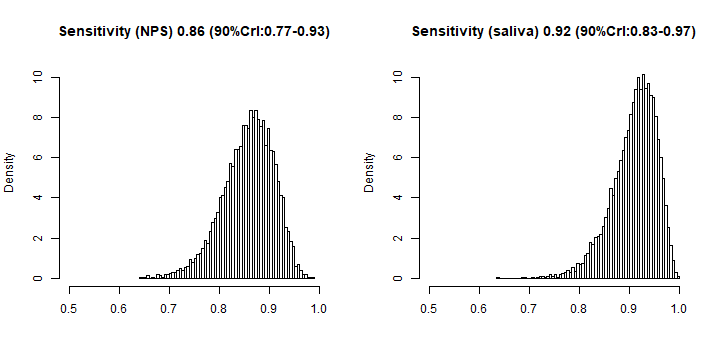

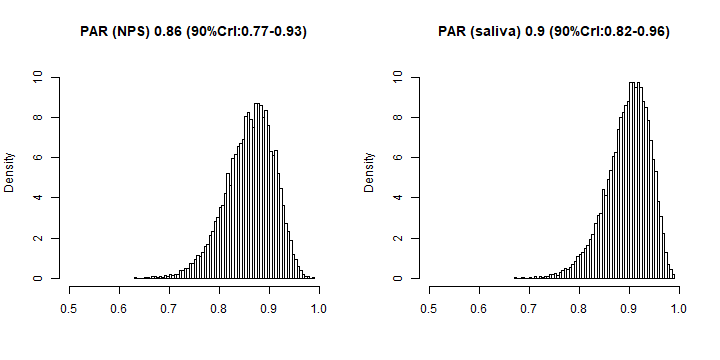

In [2]:
using RCall;@rimport graphics as rgr;@rimport repr as rpr;@rimport base as r
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 720, :height => 360)); rgr.par(mfrow=[1,2])
SeN=chain[:,"sens[1]",:].value|>vec; SeNCrI=round.(quantile.(Ref(SeN),[0.05,0.95]),digits=2)
SeS=chain[:,"sens[2]",:].value|>vec; SeSCrI=round.(quantile.(Ref(SeS),[0.05,0.95]),digits=2)
rgr.hist(SeN,xlab="",100,freq=false,xlim=[0.5,1],ylim=[0,10.5], main = "Sensitivity (NPS) "*string(round(median(SeN),digits=2))*" (90%CrI:"*prod(string.(SeNCrI[1],"-",SeNCrI[2]))*")")
rgr.hist(SeS,xlab="",100,freq=false,xlim=[0.5,1],ylim=[0,10.5], main = "Sensitivity (saliva) "*string(round(median(SeS),digits=2))*" (90%CrI:"*prod(string.(SeSCrI[1],"-",SeSCrI[2]))*")");

TN=rand(Beta(42+1,6+1),10000); TNCrI=round.(quantile.(Ref(TN),[0.05,0.95]),digits=2)
TS=rand(Beta(42+1,4+1),10000); TSCrI=round.(quantile.(Ref(TS),[0.05,0.95]),digits=2)
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 720, :height => 360)); rgr.par(mfrow=[1,2])
rgr.hist(TN,xlab="",100,freq=false,xlim=[0.5,1],ylim=[0,10.5], main = "PAR (NPS) "*string(round(median(TN),digits=2))*" (90%CrI:"*prod(string.(TNCrI[1],"-",TNCrI[2]))*")")
rgr.hist(TS,xlab="",100,freq=false,xlim=[0.5,1],ylim=[0,10.5], main = "PAR (saliva) "*string(round(median(TS),digits=2))*" (90%CrI:"*prod(string.(TSCrI[1],"-",TSCrI[2]))*")");

**Figure 1.** Posterior distributions of Sensitivity and positive agreement ratios (PARs)

## Excluding negative/negative data points

In addition, we can also confirm that the sensitivity estimation was almost solely dependent on positive samples (therefore reflective of PARs) by performing the same analysis but with negative/negative individuals removed from the dataset. This results in 47 contact tracing and 5 airport screening data points. The estimates of sensitivty were 88% for NSP (95% credible interval: 77-95%) and 91% (95% CrI: 82-97%), almost identical to the original estimates. This suggests that inclusion of 114 (contact tracing) and 1758 (airport screening) nagative/negative individual in the dataset was only reflected on the estimates of prevalence $p$ but almost did not contribute to narrowing down the sensitivity estimates. Here, the reference negative samples included in the analysis was only 4 for NPS and 6 for saliva, which again indicates that the estimates were informed mostly by the reference positive samples (those tested positive by the reference test) reflecting PARs.

In [3]:
ctdata₀=[38 3
         6 0]
aqdata₀=[4 1
         0 0]
inputs[:data]=(ctdata₀,aqdata₀)
inits=[merge(params,inputs)]
chain = mcmc(model,inputs,inits,50000, burnin=10000, thin=4, chains=1, verbose=true)
describe(chain)

MCMC Simulation of 50000 Iterations x 1 Chain...

Chain 1:   0% [0:02:45 of 0:02:45 remaining]
Chain 1:  10% [0:01:47 of 0:01:58 remaining]
Chain 1:  20% [0:01:31 of 0:01:53 remaining]
Chain 1:  30% [0:01:19 of 0:01:52 remaining]
Chain 1:  40% [0:01:07 of 0:01:52 remaining]
Chain 1:  50% [0:00:56 of 0:01:52 remaining]
Chain 1:  60% [0:00:45 of 0:01:53 remaining]
Chain 1:  70% [0:00:34 of 0:01:54 remaining]
Chain 1:  80% [0:00:23 of 0:01:55 remaining]
Chain 1:  90% [0:00:11 of 0:01:54 remaining]
Chain 1: 100% [0:00:00 of 0:01:55 remaining]

Iterations = 10004:50000
Thinning interval = 4
Chains = 1
Samples per chain = 10000

Empirical Posterior Estimates:
            Mean          SD         Naive SE         MCSE         ESS   
prev[1]   0.97909249 0.0207092602 0.000207092602 0.000224112225  8538.824
prev[2]   0.85650423 0.1257144329 0.001257144329 0.001240067947 10000.000
spec[1]   0.99497819 0.0049792933 0.000049792933 0.000050705911  9643.135
spec[2]   0.99496114 0.0050247721 0.000050

## Simulation of correlated viral loads in NPS/saliva samples

To further explore a possible data generating process that mimics the observation in Yokota et al. but not in line with their conslusions, we simulated hypothetical viral loads in NPS and saliva samples. For simplicity, we modelled viral loads in NPS/saliva samples as a multivariate normal distribution with a mean 0, which we assumed to have a linear relationship with Ct values. As Figure 4a of the original paper indicates, it is likely that the viral loads in NPS and saliva samples are correlated. We therefore assumed a correlation index of 0.8 between samples. As saliva samples was suggested to have a higher sensitivity than NPS samples, we assumed that a detection threshold of -0.3 for NPS and -0.5 for saliva PCR tests; i.e. NPS and saliva tests were assumed to show positive when the multivariate-normally distributed viral loads are over -0.3 and -0.5, respectively.

Based on the above settings, we simulated viral loads for 61 true postive (infected) individuals. The simulated data for true positives were classified into 2-by-2 tables and combined with 100 true negative individuals (all assumed to be negative/negative in PCR due to high specificity) to constitute a dataset of 161 samples that well imitate the contact tracing data in the original study. Kendall's W between NPS and saliva samples from 46 individuals (tested positive for at least one of the tests) showed 0.86, which was also consistent with the original result (0.87).

**Table 1.** Simulated data in 2-by-2 tables. The left subtable shows the test results of 61 true positives and the right subtable the overall dataset including 100 true negatives.

|  Infected only　| Saliva (+) | (-) | |  Overall　| Saliva (+) | (-) |
|------------|------------|-----| |----------------------------|------------|-----|
| NPS (+)    | 38         | 2   | | NPS (+)              | 38         | 2   |
| NPS (-)    | 6          | 15  | | NPS (-)                    | 6          | 115  |






infected_breakdown = r.table(NPS=(rmv .> thresholds)[1, :], saliva=(rmv .> thresholds)[2, :] |> collect) = RObject{IntSxp}
       saliva
NPS     FALSE TRUE
  FALSE    15    6
  TRUE      2   38

simulationdata = [38 2; 6 115]


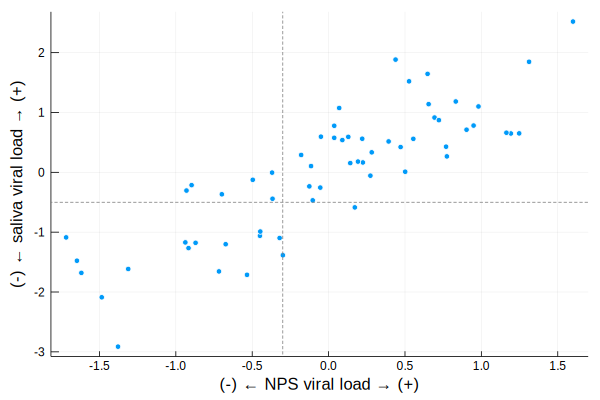

In [4]:
@rimport synchrony as sync; @rimport base as r
function generatesamples(cor,truetests,thresholds)
    truepos=truetests[1];trueneg=truetests[2]
    rmv=rand(MvNormal([1 cor;cor 1]),truepos)
    @show infected_breakdown=r.table(NPS=(rmv.>thresholds)[1,:],saliva=(rmv.>thresholds)[2,:]|>collect)
    dtable=rcopy(infected_breakdown)[[2,1],[2,1]] + [0 0;0 trueneg] # flip and add true negs
    return dtable, rmv
end
Random.seed!(2020)
thresholds=[-0.3,-0.5]
simulationdata, ctvalues=generatesamples(0.8,(61,100),thresholds)
@show simulationdata
scatter(ctvalues[1,:],ctvalues[2,:],markerstrokewidth=0,legend=false,xlabel="(-) ← NPS viral load → (+)",ylabel="(-) ← saliva viral load → (+)")
Plots.plot!([thresholds[1]], linetype=:vline,color=:gray,line=:dash);Plots.plot!([thresholds[2]], linetype=:hline,color=:gray,line=:dash)

**Figure 2.** Simulated viral loads in nasopharyingeal and saliva samples (n = 61). The dotted lines denote the assumed cutoff thresholds of -0.3 (for NPS) and -0.5 (saliva).

In [5]:
function kendallw(ctvalues,thresholds)
    positives=ctvalues[:,any(ctvalues.>thresholds,dims=1)|>vec]
    sync.kendall_w(positives')
end
kendallw(ctvalues,[-0.3,-0.5])

RObject{VecSxp}
Kendall's W (uncorrected for ties): 0.8603
Kendall's W (corrected for ties): 0.8603
Spearman's ranked correlation: 0.7205

Although this simulation data exhibited practically identical feature to the original data in every aspect, the crude sensitivity estimates for NPS and saliva PCR tests in this dataset are 66% and 72%, respectively. With a larger simulation of 10,000 individuals with 10% prevalence, we observed 62% and 67%.

infected_breakdown = r.table(NPS=(rmv .> thresholds)[1, :], saliva=(rmv .> thresholds)[2, :] |> collect) = RObject{IntSxp}
       saliva
NPS     FALSE TRUE
  FALSE   254  128
  TRUE     73  545

simulationdata_l = [545 73; 128 9254]


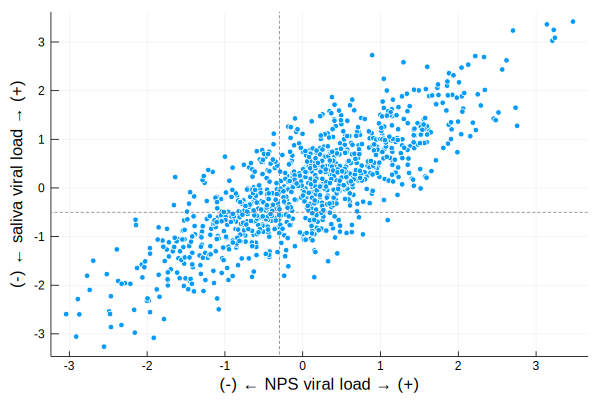

In [6]:
simulationdata_l, ctvalues_l=generatesamples(0.8,(1000,9000),thresholds)
@show simulationdata_l
scatter(ctvalues_l[1,:],ctvalues_l[2,:],markerstrokewidth=0,legend=false,xlabel="(-) ← NPS viral load → (+)",ylabel="(-) ← saliva viral load → (+)")
Plots.plot!([thresholds[1]], linetype=:vline,color=:gray,line=:dash);Plots.plot!([thresholds[2]], linetype=:hline,color=:gray,line=:dash)

**Figure 3.** Simulated viral loads in nasopharyingeal and saliva samples with a larger sample size (n = 1,000). The dotted lines denote the assumed cutoff thresholds of -0.3 (for NPS) and -0.5 (saliva).

## Conclusion

We showed that the estimated sensitivity in Yokota et al. was, in effect, only refcting posive agreement ratios (PARs) and did not necessarily capture the true sensitivity of PCR tests. The posterior distribution of sensitivity obtained from the authors' model yielded essentially identical distributions to that of PARs, and inclusion of reference negative data was found not to have contributed to estimation of sensitivity. Using a simulation of multivariate-normally distributed viral loads, we also showed that we can generate a dataset consistent with the observed contact tracing data in the original study, as well as with the observed Kendall's W of 0.87 between nasopharyngeal (NPS) and saliva samples, which nontheless points to sensitivity values below 70%.

Our results highlighted the inherent limitations of the original study design which relied on a single-point PCR test results and therefore did not have a reliable indication of true positivity. The authors used an assumption of independecy between NPS and saliva tests in the model although they also claimed a high correlation in Ct values between them. In the presence of correlation between tests, comparison between tests offer limited additional information; importantly, without an external knowledge on the true prevalence $p$, we cannot conclude the negative/negative samples were true infection negatives. In our simulation, by extending the distribution of viral loads further towards outside the cutoff thresholds, one can even lower the simulated sensitivity while remaining to be consistent with the presented data in the original study. In practice, theese samples with viral loads lower than the cutoff values could appear as those who are infected but sampled too early or too late (i.e. missed the peak of viral replication); they could also be due to individual-level variation in viral load or simply insufficient sample quality. Limited data description and absence of follow-up, it is difficult to assess to what extent these factors could have been involved, and as a result, it is unclear whether we can safely assume that most negative/negative individuals were truly uninfected, which was a critical assumption to support the authors' conclusion of high sensitivity. The concordance between NPS and saliva tests remains to be an important finding in this study that may potentially reduce burden in testing. However, we believe that the authors should not have present their estimates as sensitivity because it was essentially PAR in their study design, and that such limitations should have been clarified and discussed in the paper.